## Imports

In [1]:
from math import *
import numpy as np
import pandas as pd

#to read theb data
from pathlib import Path
import glob 

#for plots
import matplotlib.pyplot as plt
import seaborn as sns

#stats
from scipy.stats import kurtosis


## Reading the Data

In [2]:
path = r'C:/Users/varsh/OneDrive/Desktop/Honours/Daily_data_Sydney'
all_files = glob.glob(path + "/*.xlsx")
path
all_files
#Concatanating the individual datasets into one dataframe
df = pd.concat((pd.read_excel(f, header= None, index_col = 0) for f in all_files))

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7275 entries, 19591201 to 20200331
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       6789 non-null   float64
dtypes: float64(1)
memory usage: 113.7+ KB


## Cleaning the Data

In [3]:
df = df.reset_index()

In [4]:
#rename the columns 
df = df.rename(columns = {0: 'date', 1: 'temp'})

In [5]:
#there are some rows where the date column still has the temperature delimited by a space
df[["date2", "temp2"]] = df["date"].str.split(expand = True)

In [6]:
#this returns 2 columns date2 and temp2 with only the columns that were combined
#so we copy across the date and temp and drop the temporary ones
df.loc[~df.date2.isna(), "date"] = df.loc[~df.date2.isna(), "date2"]

df["temp"] = df["temp"].fillna(df["temp2"])

df = df.drop(columns = ["date2", "temp2"])

In [7]:
#convert the column to a datetime object
df["date"] = pd.to_datetime(df['date'], format="%Y%m%d")

In [8]:
#create columns for the day, month and year
df["month"] = pd.DatetimeIndex(df['date']).month
df["year"] = pd.DatetimeIndex(df['date']).year
df["day"] = pd.DatetimeIndex(df['date']).day

#these are the months in which the actual year will be equal to the summer year
months = [1,2,3]
for i in months:
    df["sYear"] = df.loc[df["month"] == i, "year"] 

#define the summer years in new column sYear
df["sYear"].bfill(inplace = True)

#define a new column, period, which categorises the years into the 2 periods
df['period'] = df['sYear'].apply(lambda x: '1960-1990' if x <= 1990 else '1991-2021')

In [9]:
#change variable types 
df["temp"] = df["temp"].astype(float)
df["sYear"] = df["sYear"].astype(int)

In [10]:
#there are a few invalid entries which we will turn to NaN values
df.loc[df["temp"]>50, "temp"] = None 

#we will take the average of the day before and after to replace those
df.temp = (df.temp.ffill()+df.temp.bfill())/2


In [11]:
#setting design of graphs 
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':20,
          'axes.facecolor':'#fafafa',
         'figure.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

In [12]:
df.tail()

,date,temp,month,year,day,sYear,period
7270,2020-03-27,33.9,3,2020,27,2020,1991-2021
7271,2020-03-28,26.2,3,2020,28,2020,1991-2021
7272,2020-03-29,26.1,3,2020,29,2020,1991-2021
7273,2020-03-30,24.8,3,2020,30,2020,1991-2021
7274,2020-03-31,27.1,3,2020,31,2020,1991-2021


In [13]:
df["temp"].quantile(0.9)

30.4

In [14]:
df.to_csv("dailydata.csv")

## Visualisations

In [15]:
#colour pallete
colourP = ["#003f5c","#955196","#dd5182", "#ff6e54", "#ffa600"]

In [16]:
def daysPChart(df, title, quantile = 0.9, period = '1st'):
    if period == '1st':
        p = df.period.unique()[0]
        percentile = df[df.period == p].temp.quantile(quantile)
    else:
        percentile = df.temp.quantile(quantile)
    
    ax = df[df["temp"]>percentile].groupby("sYear")["temp"].count().plot(marker = 'o', color = 'black', figsize = (14,8))
    ax.axvline(1990.5, linestyle='--', color = 'red')
    ax.set_xlabel("Summer Year")
    ax.set_ylabel("Days Above " + str(quantile*100) + "th Percentile")
    
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    annotateTxt = str(str(quantile*100) + "th Percentile = " + str(round(percentile,2)) + "°C")
    ax.text(xmin + 5 , ymax - 5, annotateTxt, bbox=dict(boxstyle="round,pad=0.5", fc="lightgrey", ec="red", lw=2))
    plt.title(title)
    


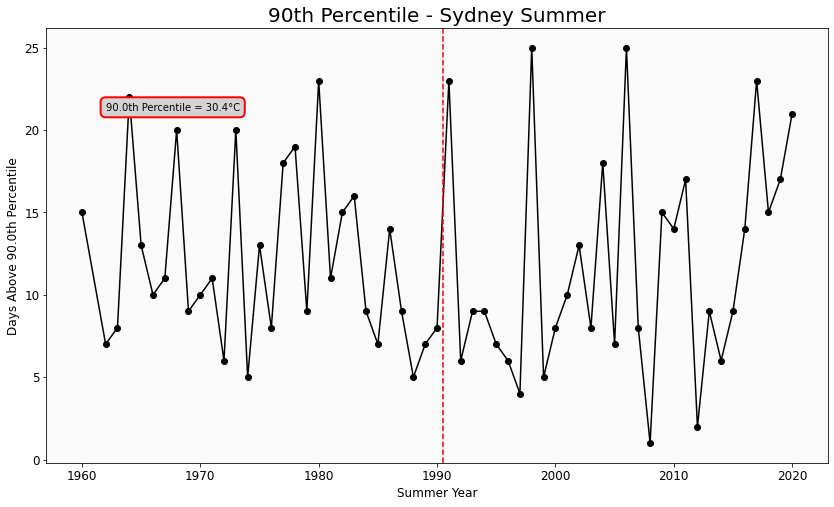

In [17]:
daysPChart(df, quantile = 0.9, period ='whole', title = "90th Percentile - Sydney Summer")

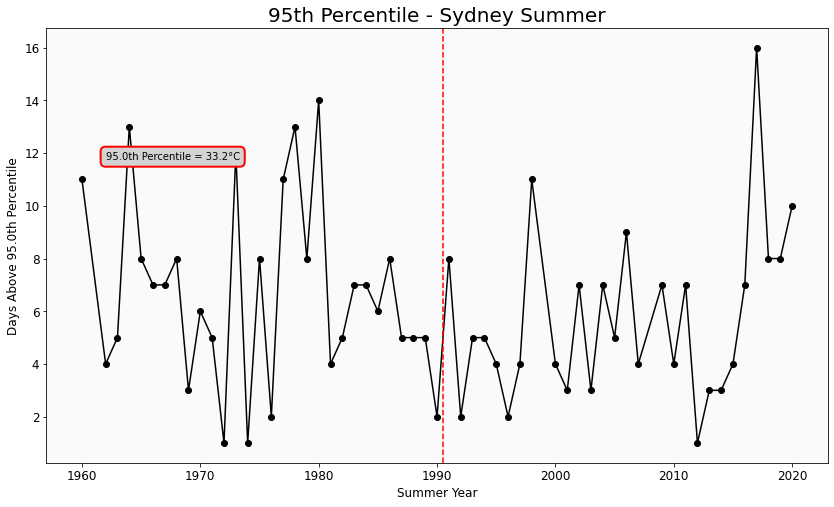

In [18]:
daysPChart(df, quantile = 0.95, period ='whole', title = "95th Percentile - Sydney Summer")

In [19]:
df[df.temp > df.temp.quantile(0.90)].groupby("period")["temp"].count()

period
1960-1990    358
1991-2021    354
Name: temp, dtype: int64

In [20]:
df[df.temp > df.temp.quantile(0.95)].groupby("period")["temp"].count()

period
1960-1990    201
1991-2021    161
Name: temp, dtype: int64

## Using the percentiles calculated from 1961-1991

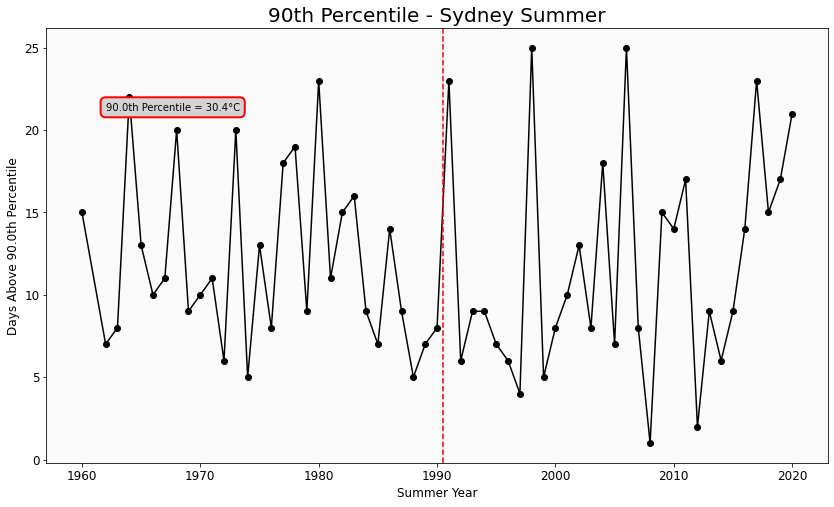

In [21]:
daysPChart(df, quantile = 0.9, period ='1st', title = "90th Percentile - Sydney Summer")

In [22]:
df[df.temp > df[df.period == '1960-1990'].temp.quantile(0.90)].groupby("period")["temp"].count()

period
1960-1990    358
1991-2021    354
Name: temp, dtype: int64

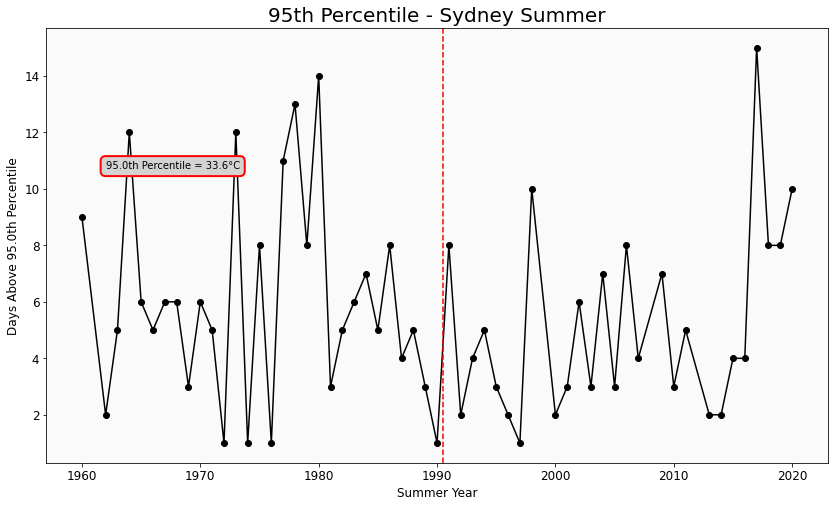

In [23]:
daysPChart(df, quantile = 0.95, period ='1st', title = "95th Percentile - Sydney Summer")

In [24]:
df[df.temp > df[df.period == '1960-1990'].temp.quantile(0.95)].groupby("period")["temp"].count()

period
1960-1990    181
1991-2021    139
Name: temp, dtype: int64

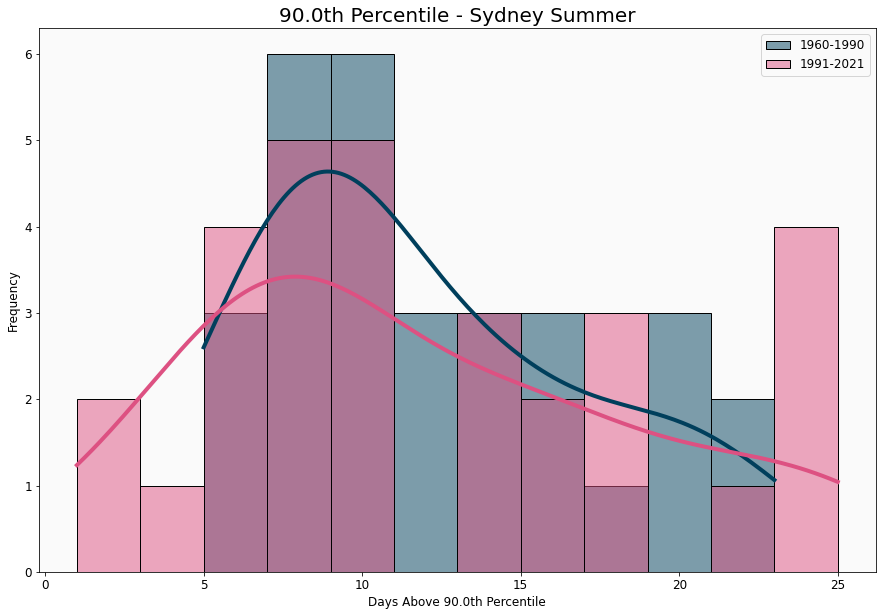

In [25]:
q = 0.9
period1 = "1960-1990"
period2 = "1991-2021"

percentile = df[df["period"] ==period1]["temp"].quantile(q)

data90_1 = df[(df["temp"] > percentile) & (df["period"] == period1)].groupby("sYear")["temp"].count()
data90_2 = df[(df["temp"] > percentile) & (df["period"] == period2)].groupby("sYear")["temp"].count()

plt.rcParams["figure.figsize"] = (15,10)

sns.histplot(x = data90_1, color = colourP[0], label = period1, kde = True, alpha = 0.5, binwidth = 2, line_kws={'linewidth':4})
sns.histplot(x = data90_2, color = colourP[2], label = period2, kde = True, alpha = 0.5, binwidth = 2, line_kws={'linewidth':4})

plt.xlabel("Days Above " + str(q*100) + "th Percentile")
plt.ylabel("Frequency")

plt.title(str(q*100) + "th Percentile - Sydney Summer")
plt.legend()
plt.show()

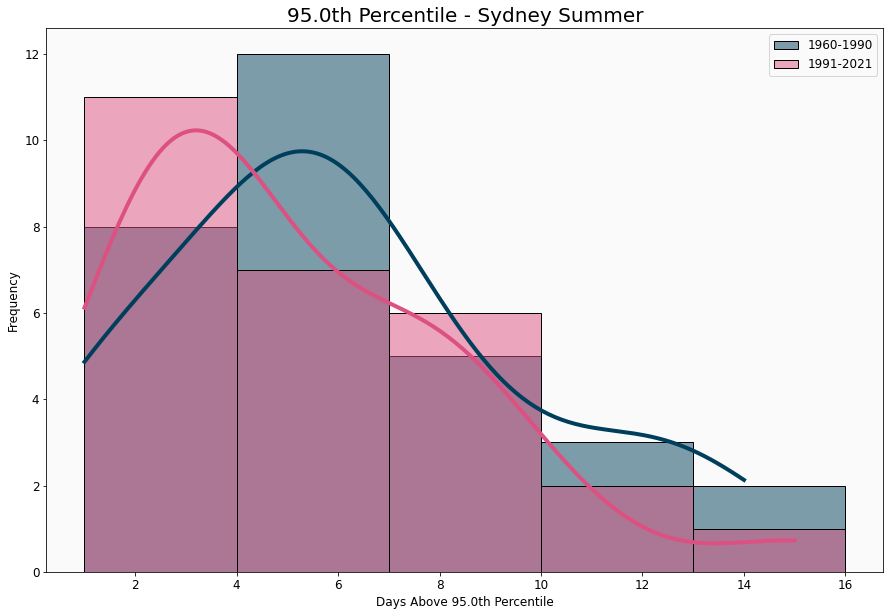

In [26]:
q = 0.95
period1 = "1960-1990"
period2 = "1991-2021"

percentile = df[df["period"] ==period1]["temp"].quantile(q)

data95_1 = df[(df["temp"] > percentile) & (df["period"] == period1)].groupby("sYear")["temp"].count()
data95_2 = df[(df["temp"] > percentile) & (df["period"] == period2)].groupby("sYear")["temp"].count()

plt.rcParams["figure.figsize"] = (15,10)

sns.histplot(x = data95_1, color = colourP[0], label = period1, kde = True, alpha = 0.5, binwidth = 3, line_kws={'linewidth':4})
sns.histplot(x = data95_2, color = colourP[2], label = period2, kde = True, alpha = 0.5, binwidth = 3, line_kws={'linewidth':4})

plt.xlabel("Days Above " + str(q*100) + "th Percentile")
plt.ylabel("Frequency")
plt.title(str(q*100) + "th Percentile - Sydney Summer")
plt.legend()
plt.show()

## Permutation testing

In [27]:
#### STEP TWO
# PERMUTATION FUNCTION   

def dbarFunc(x1,x2, func = "mean", q = 25):
    if func == "mean":
        dbar = np.mean(x1) - np.mean(x2)
    elif func == "variance":
        dbar = np.var(x1) - np.var(x2)
    elif func == "median":
        dbar = np.median(x1) - np.median(x2)
    elif func == "percentile":
        dbar = np.percentile(x1, q) - np.percentile(x2, q) 
    return dbar

# Loop (typically 5,000 times) to sample the entire time series WITHOUT replacement, 
# so that there are two vectors of samples (s1 and s2) of the original data that are the same size as vectors x1 and x2.

def resample_means(x1, x2, num = 10000, func = "mean", q = 25):
    #initialsise list for holding the resampled means z
    z = []
    #combine the samples into one list
    x1.dropna(inplace=True)
    x2.dropna(inplace = True)
    samples = x1.append(x2)
    samples.dropna(inplace=True) #in the instance x1 and x2 are inequal but the dataset 
    x1Len = np.count_nonzero(~np.isnan(x1)) #len without NaN

    #calculate dbar, the mean difference over the two periods, mean(x2) - mean(x1)
    dbar = dbarFunc(x1, x2, func = func, q = q)
    #iterate num times to sample the entire seriess WITHOUT replacement and take the dbar of these value and store in z
    for n in range(int(num)):
        resample = np.random.choice(samples, len(samples), replace = False)
        sample1 = resample[:x1Len]
        sample2 = resample[x1Len:]
        #Take the differences in mean between these resamples and store in z
        dbardash = dbarFunc(sample1, sample2, func=func, q =q)
        z.append(dbardash)
    
    return dbar, z

In [28]:
#### STEP THREE

# the p-value (for significance) can be calculated by taking the average of all resamples exceeding 
# the observed mean (both the absolute value of the observed mean and the negative absolute value). 
# i.e. p-value = (sum(z >= abs(dbar)) + sum(z <= -abs(dbar)))/n where n is the number of resamples.

def p_value(x1, x2, num = 5000, func = 'mean',q = 25):
    
    dbar, z = resample_means(x1, x2, num, func = func, q = q)
    
    values = sum([1 for i in z if i >= abs(dbar) or i <= - abs(dbar)])
    p = values/num
    return dbar, z, p
# Permutation Testing - Difference in Means for All Years

## p-values for days over 90th/95th percentile in first period

In [29]:


dbar_mean90, z_mean90, p_mean90 = p_value(data90_1, data90_2, func = 'mean')
dbar_med90, z_med90, p_med90 = p_value(data90_1, data90_2, func = 'median')

dbar_mean95, z_mean95, p_mean95 = p_value(data95_1, data95_2, func = 'mean')
dbar_med95, z_med95, p_med95 = p_value(data95_1, data95_2, func = 'median')


In [30]:
pValues = pd.DataFrame(index = ["mean", "median"])

In [31]:
pValues["90th Percentile"] = [p_mean90,p_med90]
pValues["95th Percentile"] = [p_mean95,p_med95]

In [32]:
pValues

,90th Percentile,95th Percentile
mean,0.9498,0.3476
median,0.6086,0.2070


## p-values for days over 90th/95th percentile for whole period

In [33]:
pValues2 = pd.DataFrame(index = ["mean", "median"])

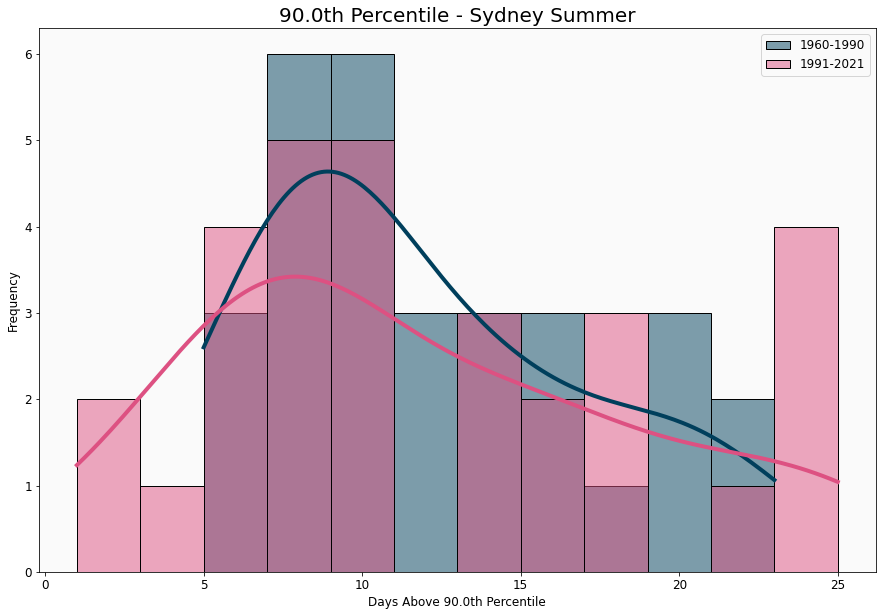

In [34]:
#90th percentile
percentile = df["temp"].quantile(0.9)
q = 0.9
data90_1 = df[(df["temp"] > percentile) & (df["period"] == period1)].groupby("sYear")["temp"].count()
data90_2 = df[(df["temp"] > percentile) & (df["period"] == period2)].groupby("sYear")["temp"].count()

dbar_mean90, z_mean90, p_mean90 = p_value(data90_1, data90_2, func = 'mean')
dbar_med90, z_med90, p_med90 = p_value(data90_1, data90_2, func = 'median')

pValues2["90th Percentile"] = [p_mean90,p_med90]

plt.rcParams["figure.figsize"] = (15,10)

sns.histplot(x = data90_1, color = colourP[0], label = period1, kde = True, alpha = 0.5, binwidth = 2, line_kws={'linewidth':4})
sns.histplot(x = data90_2, color = colourP[2], label = period2, kde = True, alpha = 0.5, binwidth = 2, line_kws={'linewidth':4})

plt.xlabel("Days Above " + str(q*100) + "th Percentile")
plt.ylabel("Frequency")
plt.title(str(q*100) + "th Percentile - Sydney Summer")
plt.legend()
plt.show()


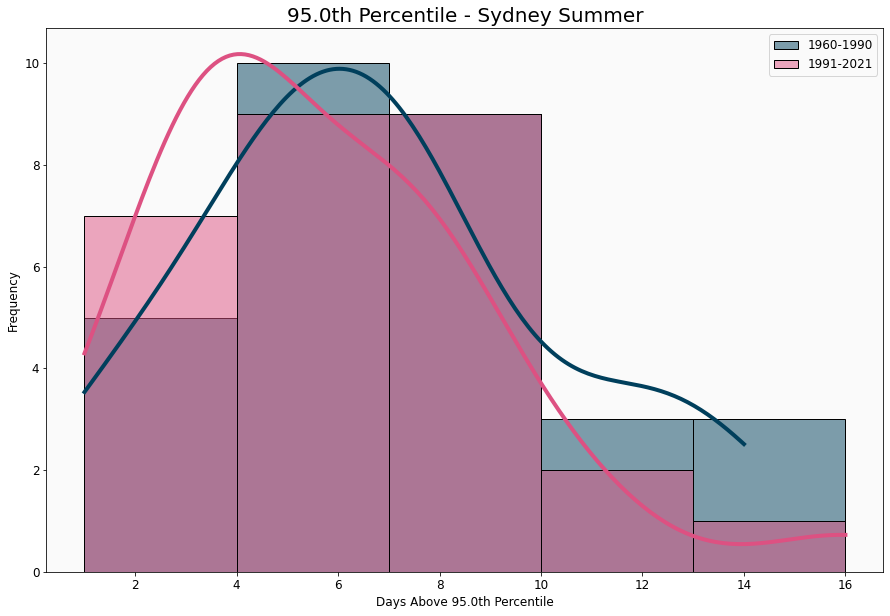

In [35]:
#95th percentile
percentile = df["temp"].quantile(0.95)
q = 0.95
data95_1 = df[(df["temp"] > percentile) & (df["period"] == period1)].groupby("sYear")["temp"].count()
data95_2 = df[(df["temp"] > percentile) & (df["period"] == period2)].groupby("sYear")["temp"].count()

dbar_mean95, z_mean95, p_mean95 = p_value(data95_1, data95_2, func = 'mean')
dbar_med95, z_med95, p_med95 = p_value(data95_1, data95_2, func = 'median')

pValues2["95th Percentile"] = [p_mean95,p_med95]

#chart
plt.rcParams["figure.figsize"] = (15,10)

sns.histplot(x = data95_1, color = colourP[0], label = period1, kde = True, alpha = 0.5, binwidth = 3, line_kws={'linewidth':4})
sns.histplot(x = data95_2, color = colourP[2], label = period2, kde = True, alpha = 0.5, binwidth = 3, line_kws={'linewidth':4})

plt.xlabel("Days Above " + str(q*100) + "th Percentile")
plt.ylabel("Frequency")
plt.title(str(q*100) + "th Percentile - Sydney Summer")
plt.legend()
plt.show()

In [36]:
pValues2

,90th Percentile,95th Percentile
mean,0.9494,0.3004
median,0.6058,0.6912
